In [1]:
# Import necessary libraries
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import h5py
import torch.nn as nn
import numpy as np

import torch
from torch.utils.data import Dataset
import h5py
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
input_filename = '/mnt/f/hprc/segments.hdf5'
train_dataset_label = "train"
val_dataset_label = "val"
test_dataset_label = "test"

In [13]:
class DNADataset(Dataset):
    def __init__(self, hdf5_file_path, split='train', chunk_size=512, overlap=0, mask_prob=0.15):
        self.hdf5_file_path = hdf5_file_path
        self.split = split  # 'train', 'val', 'test'
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.mask_prob = mask_prob
        self.vocab_size = 6  # 4 nucleotides + 1 [MASK] token + 1 padding index

        self.padding_index = self.vocab_size - 1  # Padding index
        self.mask_token_index = self.vocab_size - 2  # [MASK] token index

        self.nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}  # No unknown nucleotide

        self.hdf5_file = None  # Will be opened per worker
        self.chunks = None

    def _create_chunks(self):
        chunks = []
        for idx, seq in enumerate(self.sequences):
            seq_len = len(seq)
            if seq_len == 0:
                continue  # Skip empty sequences
            if seq_len <= self.chunk_size:
                chunks.append((idx, 0, seq_len))
            else:
                step = self.chunk_size - self.overlap
                for start in range(0, seq_len - self.chunk_size + 1, step):
                    end = start + self.chunk_size
                    chunks.append((idx, start, end))
                # Handle the last chunk if it doesn't fit exactly
                if (seq_len - self.chunk_size) % step != 0:
                    start = seq_len - self.chunk_size
                    end = seq_len
                    chunks.append((idx, start, end))
        return chunks

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        seq_idx, start, end = self.chunks[idx]
        seq = self.sequences[seq_idx][start:end]
        seq_tensor = torch.from_numpy(seq).long()  # Shape: (seq_len,)

        # Apply masking for MLM
        input_seq, labels = self._apply_masking(seq_tensor)

        # Convert to one-hot encoding
        one_hot_input_seq = torch.nn.functional.one_hot(input_seq, num_classes=self.vocab_size).float()  # Shape: (seq_len, vocab_size)

        return one_hot_input_seq, labels

    def _apply_masking(self, seq_tensor):
        seq_len = seq_tensor.size(0)
        labels = seq_tensor.clone()  # Original labels

        # Create mask for MLM
        mask = torch.rand(seq_len) < self.mask_prob  # Decide which positions to mask
        labels[~mask] = -100  # We only compute loss on masked positions

        # Replace masked positions with [MASK] token index
        input_seq = seq_tensor.clone()
        input_seq[mask] = self.mask_token_index  # [MASK] token index

        return input_seq, labels

    def __del__(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()  # Close the HDF5 file when the object is deleted


In [14]:
def collate_fn(batch):
    inputs = [item[0] for item in batch]  # Each item[0] is a tensor of shape (seq_len, vocab_size)
    labels = [item[1] for item in batch]  # Each item[1] is a tensor of shape (seq_len,)

    seq_lengths = [input_seq.size(0) for input_seq in inputs]
    max_length = max(seq_lengths)
    batch_size = len(inputs)
    vocab_size = inputs[0].size(1)

    # Initialize tensors for inputs and labels
    padded_inputs = torch.zeros(batch_size, max_length, vocab_size)  # Padding with zeros
    padded_labels = torch.full((batch_size, max_length), fill_value=-100, dtype=torch.long)

    for i in range(batch_size):
        seq_len = inputs[i].size(0)
        padded_inputs[i, :seq_len, :] = inputs[i]
        padded_labels[i, :seq_len] = labels[i]

    return padded_inputs, padded_labels


In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size - 2)  # Exclude [MASK] token and padding index
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_key_padding_mask=None):
        # src: (batch_size, seq_len, vocab_size)
        x = self.input_linear(src)  # Shape: (batch_size, seq_len, d_model)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # Transformer expects input as (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        output = self.output_layer(x)  # Shape: (batch_size, seq_len, vocab_size - 1)
        return output


In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create datasets
train_dataset = DNADataset(hdf5_file_path=input_filename, split=train_dataset_label, chunk_size=512, overlap=0)
val_dataset = DNADataset(hdf5_file_path=input_filename, split=val_dataset_label, chunk_size=512, overlap=0)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Model parameters
vocab_size = train_dataset.vocab_size  # 4 nucleotides + 1 unknown + 1 [MASK] token + 1 padding index
d_model = 128
num_heads = 8
num_layers = 4
dim_feedforward = 512
dropout = 0.1
learning_rate = 1e-4

# Initialize model, criterion, and optimizer
model = TransformerModel(vocab_size=vocab_size, d_model=d_model, num_heads=num_heads,
                         num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_inputs, batch_labels in tqdm(train_loader):
        batch_inputs = batch_inputs.to(device)  # Shape: (batch_size, seq_len, vocab_size)
        batch_labels = batch_labels.to(device)  # Shape: (batch_size, seq_len)

        optimizer.zero_grad()

        # Create src_key_padding_mask: True for padding positions
        src_key_padding_mask = torch.all(batch_inputs == 0, dim=-1)  # Shape: (batch_size, seq_len)

        outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)  # Shape: (batch_size, seq_len, vocab_size - 1)

        # Adjust labels: map padding index to -100
        adjusted_labels = batch_labels.clone()
        adjusted_labels[adjusted_labels == train_dataset.padding_index] = -100  # Ignore padding positions

        # Remove [MASK] token index from labels (if present)
        adjusted_labels[adjusted_labels == train_dataset.mask_token_index] = -100  # Ignore masked positions in loss

        # Ensure labels are within [0, vocab_size - 3] (since vocab_size - 1 is padding index, and vocab_size - 2 is [MASK] token)
        valid_label_mask = (adjusted_labels >= 0) & (adjusted_labels <= 3)
        adjusted_labels[~valid_label_mask] = -100  # Ignore any invalid labels

        # Compute loss
        loss = criterion(outputs.view(-1, vocab_size - 2), adjusted_labels.view(-1))

        if not torch.isfinite(loss):
            print("Loss is NaN or Inf, skipping batch")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(val_loader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            src_key_padding_mask = torch.all(batch_inputs == 0, dim=-1)

            outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)

            adjusted_labels = batch_labels.clone()
            adjusted_labels[adjusted_labels == train_dataset.padding_index] = -100
            adjusted_labels[adjusted_labels == train_dataset.mask_token_index] = -100 # train_dataset.unknown_nucleotide_index

            loss = criterion(outputs.view(-1, vocab_size - 1), adjusted_labels.view(-1))

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


/home/hamed/hprc_graph_embedding/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 181/181 [00:01<00:00, 144.60it/s]


Epoch 1/10, Train Loss: 1.3303, Validation Loss: 1.3596


100%|██████████| 181/181 [00:01<00:00, 140.17it/s]


Epoch 2/10, Train Loss: 1.3259, Validation Loss: 1.3547


100%|██████████| 181/181 [00:01<00:00, 140.61it/s]


Epoch 3/10, Train Loss: 1.3230, Validation Loss: 1.3458


100%|██████████| 181/181 [00:01<00:00, 143.69it/s]


Epoch 4/10, Train Loss: 1.3059, Validation Loss: 1.3228


100%|██████████| 181/181 [00:01<00:00, 149.39it/s]


Epoch 5/10, Train Loss: 1.0532, Validation Loss: 1.1593


100%|██████████| 181/181 [00:01<00:00, 147.61it/s]


Epoch 6/10, Train Loss: 0.7533, Validation Loss: 1.0610


100%|██████████| 181/181 [00:01<00:00, 125.58it/s]


Epoch 7/10, Train Loss: 0.6141, Validation Loss: 1.0391


100%|██████████| 181/181 [00:01<00:00, 131.22it/s]


Epoch 8/10, Train Loss: 0.5135, Validation Loss: 0.9758


100%|██████████| 181/181 [00:01<00:00, 139.49it/s]


Epoch 9/10, Train Loss: 0.4197, Validation Loss: 0.9598


100%|██████████| 181/181 [00:01<00:00, 128.68it/s]

Epoch 10/10, Train Loss: 0.3410, Validation Loss: 0.9413


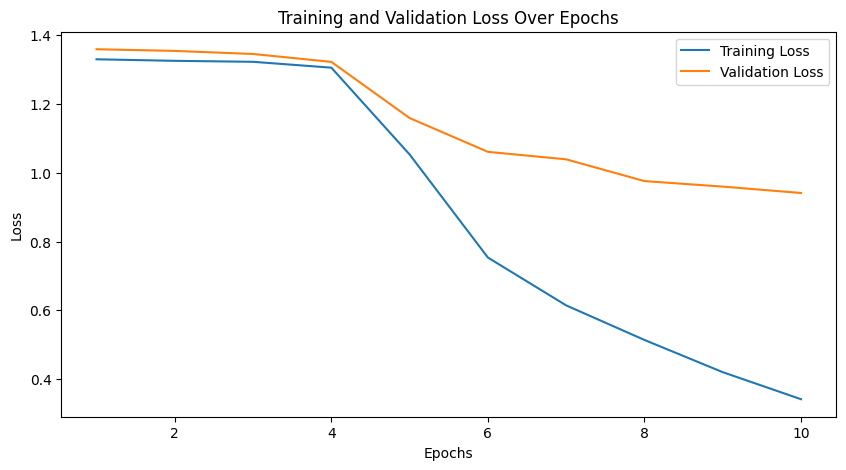

In [21]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()